In [1]:
import xarray as xr
import os
import numpy as np
import pandas as pd

In [70]:
local_file='E:\\weatherbench\\2.8125deg\\2.8125deg\\2m_temperature\\2m_temperature_2.8125deg'

In [69]:
lats = [40.78125, 43.59375]
lons = [284.0625, 286.875]

In [67]:
def get_daily_temp_for_year(lat, lon, year):
    d = xr.open_dataset(os.path.join(local_file, f"2m_temperature_{year}_2.8125deg.nc"))
    one_slice = dict(lat=slice(lat, lat+1), lon=slice(lon, lon+1))
    data = d.loc[one_slice].to_dataframe()
    temps = data.query(f"lon=={lon} and lat=={lat}")['t2m']
    # hourly temperature: each day covers 24 entries. Take the daily average over 24hrs
    one_year_daily=np.array([np.mean(temps[i:i+24]) for i in range(0, len(temps), 24)])
    return one_year_daily[:365].reshape((1, 365))

In [68]:
def linearize(x):
    linearized = np.array([])
    for chunk in x:
        linearized = np.concatenate((linearized, chunk), axis=0)
    return linearized

In [71]:
def detrend(lat, lon, nombor):
    data = None
    for y in range(1979, 2019):
        more_data = get_daily_temp_for_year(lat, lon, y)
        if data is None:
            data = more_data
        else:
            data = np.concatenate((data, more_data), axis=0)
    np.savetxt(f"daily_averages{nombor}.txt", data, delimiter=',')
    means = np.array([np.array([data[i, j] for i in range(40)]).mean() for j in range(365)])
    detrended = data - means
    np.savetxt(f"detrended{nombor}.txt", linearize(detrended), delimiter=',')

In [72]:
i = 0
for lat in lats:
    for lon in lons:
        print(f'lat:{lat}, lon:{lon}, {i}')
        detrend(lat, lon, i)
        i += 1

lat:40.78125, lon:284.0625, 0
lat:40.78125, lon:286.875, 1
lat:43.59375, lon:284.0625, 2
lat:43.59375, lon:286.875, 3


In [3]:
import emd
data = np.loadtxt("daily_averages.txt")
data_centred = data - data.mean()

In [4]:
imf = emd.sift.sift(data_centred)

<AxesSubplot:xlabel='Time (samples)'>

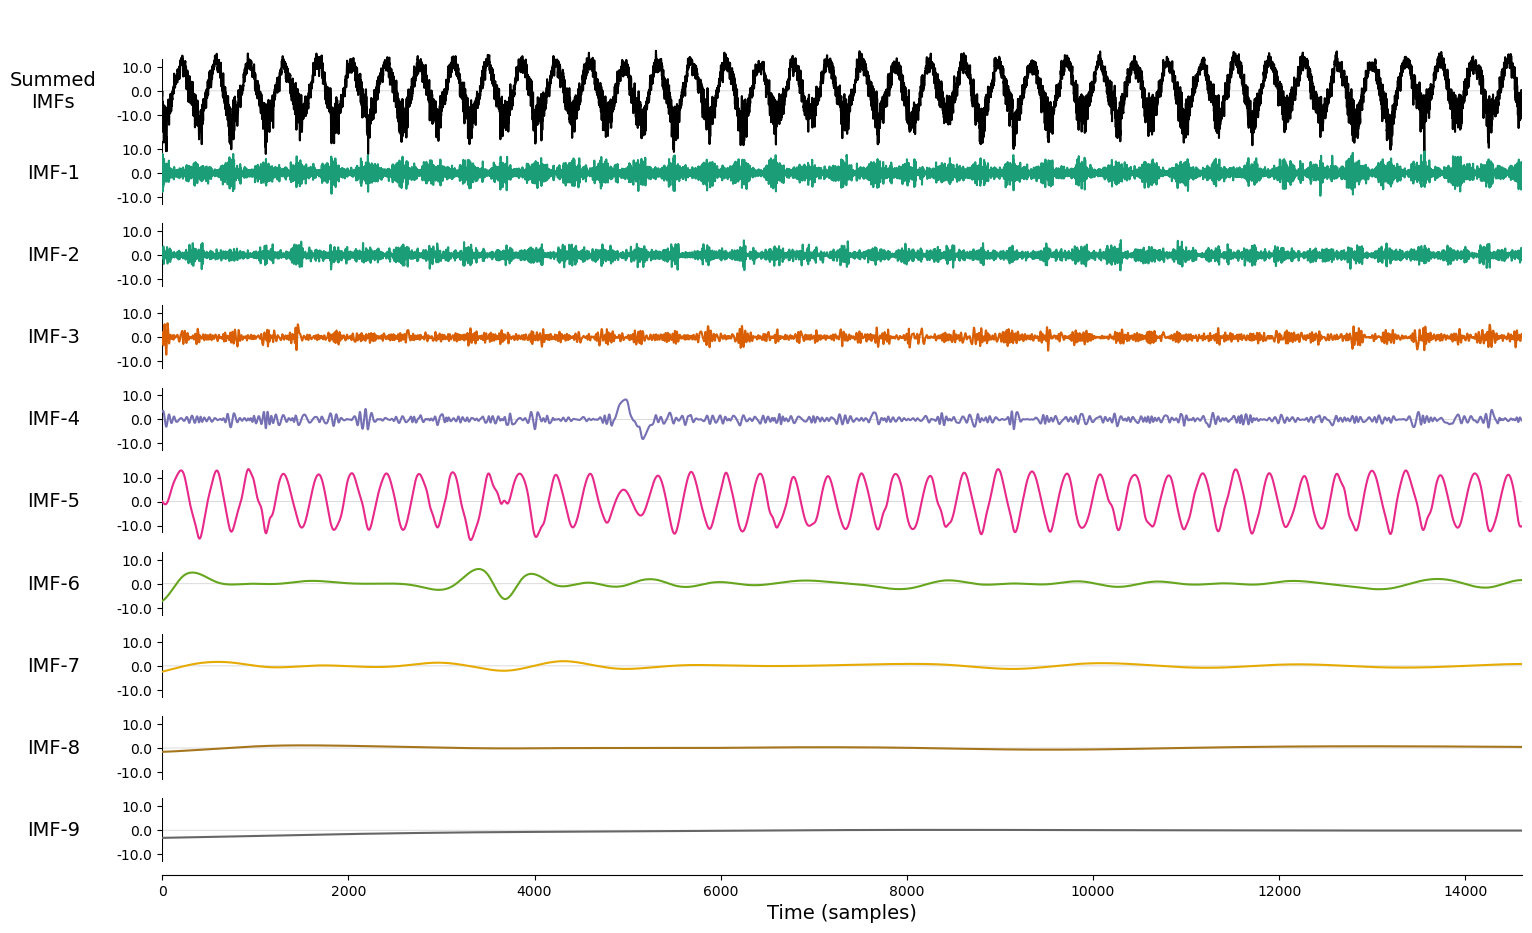

In [5]:
emd.plotting.plot_imfs(imf)

In [22]:
detrend=np.array([np.sum([imf[i,j] for j,val in enumerate(imf[i]) if j<3]) for i in range(imf.shape[0])])

<AxesSubplot:xlabel='Time (samples)'>

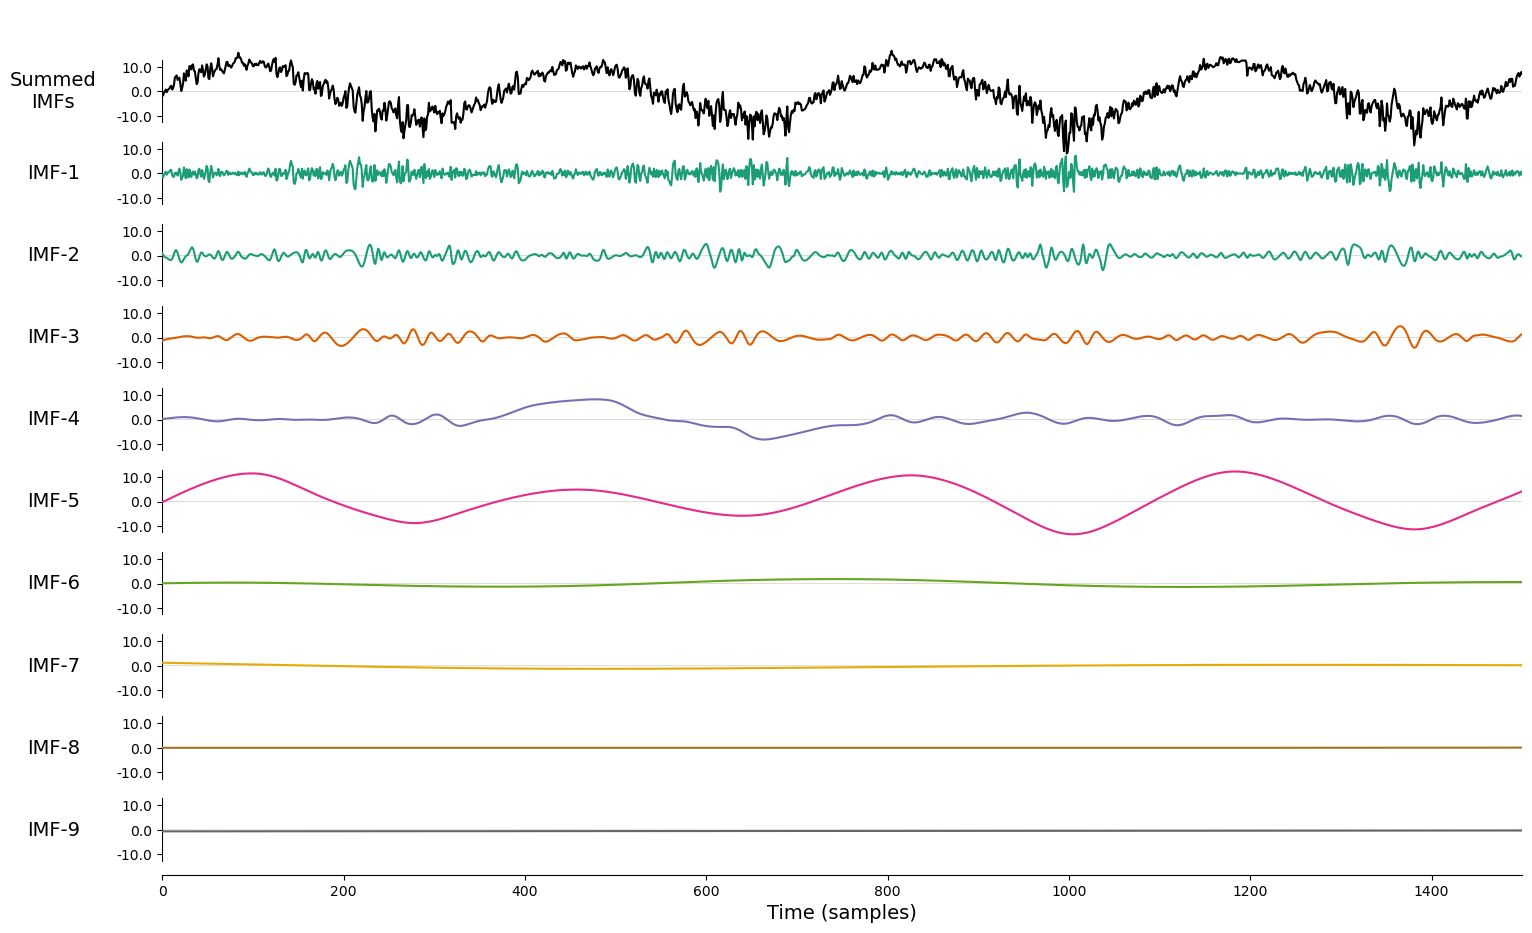

In [14]:
sub = imf[4500:6000]
emd.plotting.plot_imfs(sub)

<AxesSubplot:xlabel='Time (samples)'>

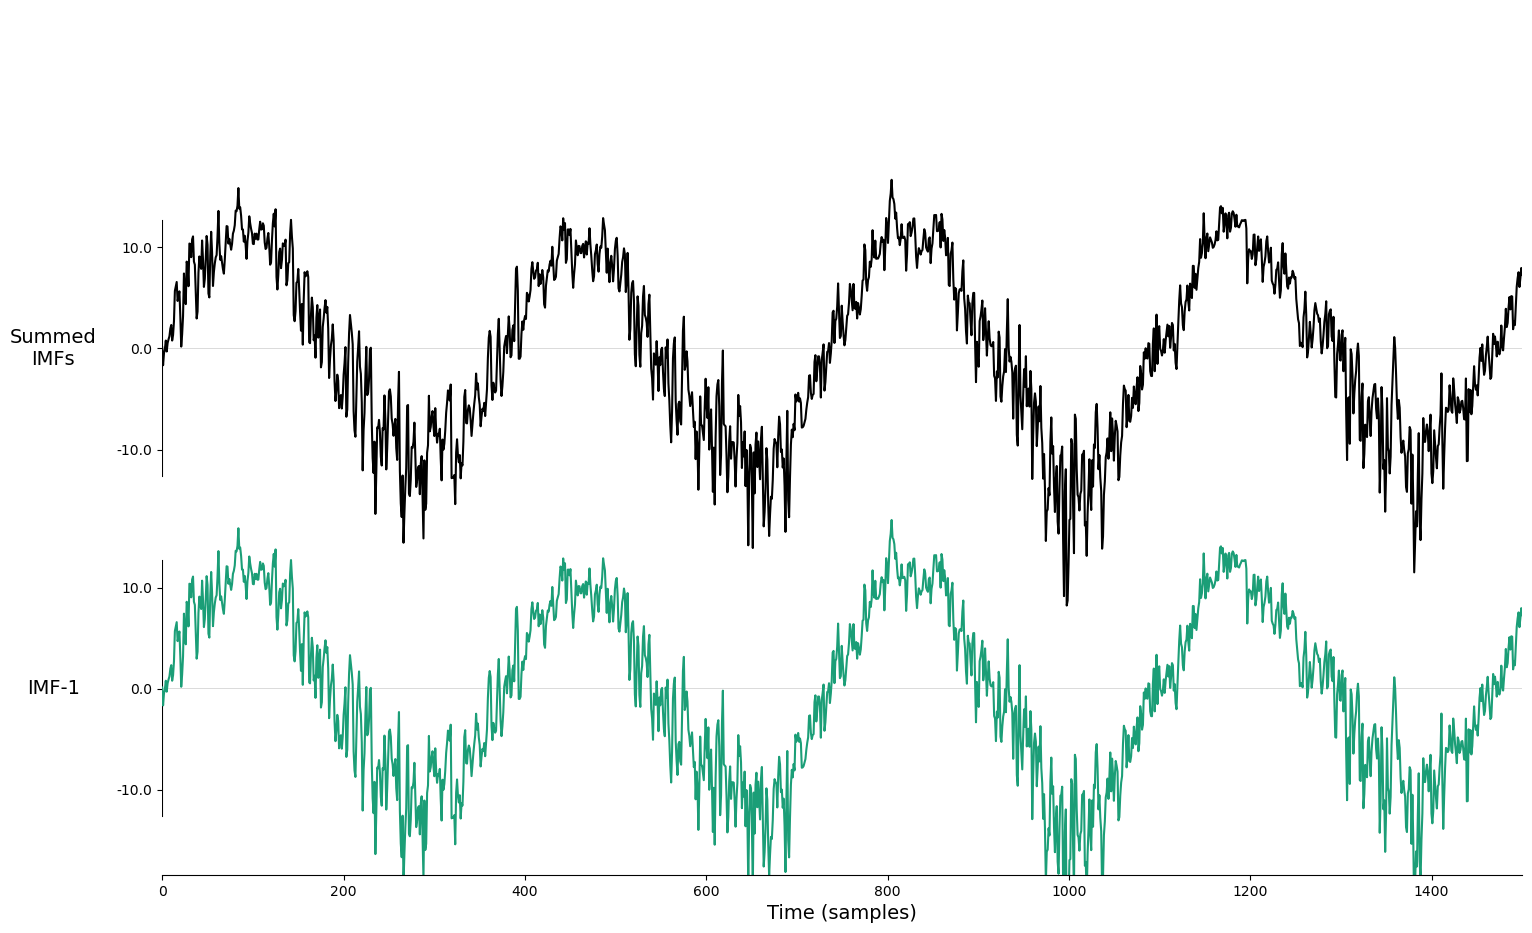

In [26]:
x = data_centred[4500:6000].reshape((1500,1))
emd.plotting.plot_imfs(x)

In [16]:
data = None
for i in range(4):
    d = np.loadtxt(f"detrended{i}.txt")
    reshaped = d.reshape(d.shape[0], 1)
    if data is None:
        data = reshaped
    else:
        data = np.concatenate((data, reshaped), axis=1)

In [22]:
df = pd.DataFrame(data, columns=['one', 'two', 'three', 'four'])
df.to_csv("forcluster.txt", index=False)